In [1]:
from esper.prelude import *
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.temporal_predicates import overlaps
from esper.rekall import *
import matplotlib.pyplot as plt
import cv2

# Load up Ground Truth

In [2]:
# Load up small ground truth test set - two easy sequences, one hard
shots_gt_training_qs = Shot.objects.filter(
    Q(video_id=123, labeler__name__contains='manual', max_frame__lte=16560) | # easy
    Q(video_id=172, labeler__name__contains='manual') | # hard
    Q(video_id=179, labeler__name__contains='manual') # easy
)

In [3]:
shots_gt_test_qs = Shot.objects.filter(labeler__name__contains='manual')

In [4]:
shots_gt_training = VideoIntervalCollection.from_django_qs(shots_gt_training_qs)

In [5]:
shots_gt_test = VideoIntervalCollection.from_django_qs(shots_gt_test_qs).minus(shots_gt_training)

In [ ]:
# Visualize the ground truth.
esper_widget(intrvllists_to_result(shots_gt_training), jupyter_keybindings=True, disable_captions=True)

# Evaluate Baselines

## Load up Shots from Heuristics

In [6]:
# Figure out temporal extents of the clips that were labeled
clips_training = shots_gt_training.dilate(1).coalesce().dilate(-1)
clips_test = shots_gt_test.dilate(1).coalesce().dilate(-1)

In [7]:
cinematic_shots_qs = Shot.objects.filter(cinematic=True).all()
cinematic_shots = VideoIntervalCollection.from_django_qs(
    cinematic_shots_qs,
    progress = True
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 875669/875669 [00:02<00:00, 331893.46it/s]


In [8]:
cinematic_shots_training = cinematic_shots.filter_against(
    clips_training,
    predicate=overlaps()
)
cinematic_shots_test = cinematic_shots.filter_against(
    clips_test,
    predicate=overlaps()
)

In [9]:
cinematic_shot_boundaries_training = cinematic_shots_training.map(lambda i: (i.start, i.start, i.payload))
cinematic_shot_boundaries_test = cinematic_shots_test.map(lambda i: (i.start, i.start, i.payload))
gt_shot_boundaries_training = shots_gt_training.map(lambda i: (i.start, i.start, i.payload))
gt_shot_boundaries_test = shots_gt_test.map(lambda i: (i.start, i.start, i.payload))

In [10]:
def size(interval_collection):
    count = 0
    for video_id in interval_collection.get_allintervals():
        count += interval_collection.get_intervallist(video_id).size()
        
    return count

In [11]:
def print_per_video_precision_recall(gt_shot_boundaries, eval_shot_boundaries):
    for video_id in gt_shot_boundaries.get_allintervals():
        print("Video {}: ".format(video_id))
        cine_sb = VideoIntervalCollection({
            video_id: eval_shot_boundaries.get_intervallist(video_id)
        })
        gt_sb = VideoIntervalCollection({
            video_id: gt_shot_boundaries.get_intervallist(video_id)
        })
        accurate_sb = cine_sb.filter_against(gt_sb, predicate=overlaps())
        inaccurate_sb = cine_sb.minus(accurate_sb)

        found_human_sb = gt_sb.filter_against(cine_sb, predicate=overlaps())
        missed_human_sb = gt_sb.minus(found_human_sb)
        
        print("Precision: {}, {} out of {}".format(
            size(accurate_sb) / size(cine_sb), 
            size(accurate_sb), 
            size(cine_sb)))
        print("Recall: {}, {} out of {}".format(
            size(accurate_sb) / size(gt_sb), 
            size(accurate_sb), 
            size(gt_sb)))

In [12]:
print_per_video_precision_recall(gt_shot_boundaries_training, cinematic_shot_boundaries_training)

Video 123: 
Precision: 1.0, 17 out of 17
Recall: 1.0, 17 out of 17
Video 172: 
Precision: 0.7222222222222222, 13 out of 18
Recall: 0.52, 13 out of 25
Video 179: 
Precision: 1.0, 14 out of 14
Recall: 0.875, 14 out of 16


In [18]:
print_per_video_precision_recall(gt_shot_boundaries_test, cinematic_shot_boundaries_test)

Video 65: 
Precision: 1.0, 20 out of 20
Recall: 1.0, 20 out of 20
Video 515: 
Precision: 1.0, 2 out of 2
Recall: 1.0, 2 out of 2
Video 577: 
Precision: 1.0, 21 out of 21
Recall: 1.0, 21 out of 21
Video 585: 
Precision: 1.0, 12 out of 12
Recall: 0.9230769230769231, 12 out of 13
Video 34: 
Precision: 0.7777777777777778, 7 out of 9
Recall: 0.5, 7 out of 14
Video 144: 
Precision: 0.3333333333333333, 1 out of 3
Recall: 1.0, 1 out of 1
Video 504: 
Precision: 0.96875, 31 out of 32
Recall: 0.7380952380952381, 31 out of 42
Video 339: 
Precision: 0.9, 9 out of 10
Recall: 0.9, 9 out of 10
Video 148: 
Precision: 1.0, 8 out of 8
Recall: 1.0, 8 out of 8
Video 23: 
Precision: 0.7894736842105263, 15 out of 19
Recall: 0.5769230769230769, 15 out of 26
Video 411: 
Precision: 1.0, 3 out of 3
Recall: 1.0, 3 out of 3
Video 226: 
Precision: 0.5, 3 out of 6
Recall: 0.75, 3 out of 4
Video 123: 
Precision: 0.8713450292397661, 149 out of 171
Recall: 0.9371069182389937, 149 out of 159
Video 359: 
Precision: 0.933

In [19]:
# Visualize the discrepancies. Ground truth is in red, heuristic results are in blue.
result = intrvllists_to_result(shots_gt_training, color='red')
add_intrvllists_to_result(result, cinematic_shots_training, color='blue')
esper_widget(result, jupyter_keybindings=True, disable_captions=True)

VGridWidget(jsglobals={'bucket': 'esper', 'queries': [['All faces', 'def all_faces():\n    from query.models i…

## Machine Learning

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import time
import datetime
from tqdm import tqdm
import copy
import scannertools as st
import random

In [14]:
st.init_storage(os.environ['BUCKET'])

In [78]:
class ShotDetectionDataset(Dataset):
    def __init__(self, shots, window_size=1, height=224):
        """Constrcutor for ShotDetectionDataset.
        
        Args:
            shots: VideoIntervalCollection of all the intervals to get frames from. If the payload is False,
            then the interval is not an actual shot and just needs to be included in the dataset.
        """
        self.window_size = window_size
        items = set()
        frame_nums = {}
        
        for video_id in shots.get_allintervals():
            frame_nums[video_id] = set()
            for intrvl in shots.get_intervallist(video_id).get_intervals():
                for f in range(intrvl.start, intrvl.end + 1):
                    items.add((
                        video_id,
                        f,
                        1 if f == intrvl.start and intrvl.payload != False else 0
                    ))
                    for i in range(intrvl.start - window_size, intrvl.end + window_size + 1):
                        frame_nums[video_id].add(i)
        self.items = sorted(list(items))
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((100, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Load frames into memory
        self.frames = {
            video_id: {
                'frame_nums': sorted(list(frame_nums[video_id])),
                'frames': [
                    self.transform(f)
                    for f in Video.objects.get(id=video_id).for_scannertools().frames(
                        sorted(list(frame_nums[video_id]))
                    )
                ]
            }
            for video_id in frame_nums
        }
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        """
        Indexed by video ID, then frame number
        Returns self.window_size frames before the indexed frame to self.window_size
            frames after the indexed frame
        """
        video_id, frame_num, label = self.items[idx]
        
        start_index = self.frames[video_id]['frame_nums'].index(frame_num - self.window_size)
        img_tensors = self.frames[video_id]['frames'][start_index:start_index + 2*self.window_size + 1]
        
#         img_tensors = [
#             self.transform(f)
#             for f in Video.objects.get(id=video_id).for_scannertools().frames(
#                 list(range(frame_num - self.window_size, frame_num + self.window_size + 1))
#             )
#         ]
        
        return img_tensors, label

In [51]:
# construct a training set with good class balance
shot_boundaries = shots_gt_training.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
)
shots_without_boundaries = shots_gt_training.map(
    lambda intrvl: (intrvl.start + 1, intrvl.end, intrvl.payload)
).get_allintervals()
non_boundary_frames = [
    (video_id, f)
    for video_id in shots_without_boundaries
    for intrvl in shots_without_boundaries[video_id].get_intervals()
    for f in range(intrvl.start, intrvl.end + 1)
]
random.seed(0)
random.shuffle(non_boundary_frames) # seed of 0 for reproducibility
chosen_frames = collect(non_boundary_frames[:size(shot_boundaries)], lambda tup: tup[0])

training_frames = shot_boundaries.set_union(
    VideoIntervalCollection({
        video_id: [
            (frame, frame, 0)
            for vid, frame in chosen_frames[video_id]
        ]
        for video_id in chosen_frames
    })
)

In [79]:
dataset_training = ShotDetectionDataset(training_frames)

In [91]:
dataloader_training = DataLoader(dataset_training, batch_size=8, shuffle=True, num_workers=0)

In [107]:
class VideoNet(nn.Module):
    def __init__(self):
        super(VideoNet, self).__init__()
#         self.resnet1 = models.ResNet(models.resnet.BasicBlock, [1, 1, 1, 1], num_classes=128)
#         self.resnet2 = models.ResNet(models.resnet.BasicBlock, [1, 1, 1, 1], num_classes=128)
#         self.resnet3 = models.ResNet(models.resnet.BasicBlock, [1, 1, 1, 1], num_classes=128)
        self.resnet1 = models.resnet18(pretrained=True)
        self.resnet2 = models.resnet18(pretrained=True)
        self.resnet3 = models.resnet18(pretrained=True)
    
        # Replace pooling layer with Adaptive Pooling
        self.resnet1.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.resnet2.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.resnet3.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.embeddingconv = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()
        
    def init_weights(self):
        nn.init.kaiming_normal_(self.embeddingconv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, image1, image2, image3):
        image1embedding = self.resnet1(image1).unsqueeze(1)
        image2embedding = self.resnet2(image2).unsqueeze(1)
        image3embedding = self.resnet3(image3).unsqueeze(1)
        
#         print(image1embedding.size())
        
        embedding_image = torch.cat(
            (image1embedding, image2embedding, image3embedding),
            dim=1
        )
        
#         print(embedding_image.size())
        
        embedding_image = embedding_image.unsqueeze(1)
        
#         print(embedding_image.size())
        out = self.embeddingconv(embedding_image)
#         print(out.size())
        out = self.relu(out)
#         print(out.size())
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
#         out = nn.LogSoftmax(1)(out)
#         out = self.sigmoid(out)
#         out = F.softmax(out, dim=1)
        
        return out
    
#     def parameters(self):
#         return [self.embeddingconv.parameters(), self.fc.parameters()]

In [108]:
vnet = VideoNet()

In [109]:
vnet.init_weights()

In [110]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [111]:
vnet = vnet.to(device)

In [112]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total_inputs = 0.0
            
            true_positive = 0.
            false_positive = 0.
            true_negative = 0.
            false_negative = 0.

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloader_training)):
#                 if idx > 100:
#                     break
#                 print("Start loop {}".format(datetime.datetime.now()))
                crit = nn.BCELoss(
                    weight = torch.tensor([
                        1.0 if l.item() == 1 else .25
                        for l in labels
                    ]).to(device)
                )
                inputs = [i.to(device) for i in inputs]
                labels = labels.to(device)
#                 print("Moved inputs {}".format(datetime.datetime.now()))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs[0], inputs[1], inputs[2])
                    _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs.view(1, 4), labels.view(1, 4))
#                     loss=torch.tensor([[0]]).to(device)
                    loss=criterion(outputs, labels)
#                     print(outputs.view(1, 4), labels.float().view(1, 4), loss)
#                     if False:
                    if idx == 0:
                        print(outputs, labels, loss)
#                     print(labels)
#                     print(loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                
                    for p, l in zip(preds, labels):
                        if p.item() == l.item():
                            if l.item() == 1:
                                true_positive += 1.
                            else:
                                true_negative += 1.
                        else:
                            if p.item() == 1:
                                false_positive += 1.
                            else:
                                false_negative += 1.
                        total_inputs += 1

#                     for o, l in zip(outputs, labels):
#                         if o.item() > 0.5:
#                             if l.item() == 1:
#                                 true_positive += 1.
#                             else:
#                                 false_positive += 1.
#                         else:
#                             if l.item() == 1:
#                                 false_negative += 1.
#                             else:
#                                 true_negative += 1.
                            
                    # statistics
                    running_loss += loss.item() * inputs[0].size(0)
                    running_corrects = true_positive + true_negative
#                     print(running_corrects, true_positive, true_negative, total_inputs)

#                 print("End loop {}".format(datetime.datetime.now()))

            epoch_loss = running_loss / total_inputs #/ len(dataset)
            epoch_acc = running_corrects / total_inputs #/ len(dataset)
            if true_positive + false_positive != 0:
                precision = true_positive / (true_positive + false_positive)
            else:
                precision = 0.
            if true_positive + false_negative != 0:
                recall = true_positive / (true_positive + false_negative)
            else:
                recall = 0.

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, precision, recall))
            print('TP: {} TN: {} FP: {} FN: {}'.format(
                true_positive, true_negative, false_positive, false_negative
            ))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [113]:
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([.1, 1.]).to(device))
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss(weight=torch.tensor([.01, .99]).to(device))
# criterion = nn.NLLLoss()
# criterion = nn.BCELoss()

In [114]:
optimizer = optim.SGD(vnet.parameters(), lr=0.01, momentum=0.9)

In [115]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [116]:
model = train_model(vnet, criterion, optimizer, exp_lr_scheduler, num_epochs=25)


0it [00:00, ?it/s]
2it [00:00, 12.34it/s]

Epoch 0/24
----------
tensor([[-0.0401, -0.1032],
        [-0.0353, -0.1036],
        [-0.0406, -0.1106],
        [-0.0443, -0.0928],
        [-0.0446, -0.0875],
        [-0.0370, -0.0963],
        [-0.0574, -0.0773],
        [-0.0301, -0.1004]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0') tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 13.33it/s]
6it [00:00, 13.19it/s]
8it [00:00, 13.08it/s]
10it [00:00, 13.70it/s]
12it [00:00, 13.99it/s]
14it [00:01, 13.83it/s]
15it [00:01, 13.84it/s]
0it [00:00, ?it/s]
2it [00:00, 15.55it/s]

train Loss: 0.6966 Acc: 0.5000 Precision: 0.0000 Recall: 0.0000
TP: 0.0 TN: 58.0 FP: 0.0 FN: 58.0

Epoch 1/24
----------
tensor([[-0.0518, -0.0828],
        [-0.0441, -0.0900],
        [-0.0628, -0.0767],
        [-0.0446, -0.0985],
        [-0.0320, -0.1060],
        [-0.0699, -0.0564],
        [-0.0311, -0.0981],
        [-0.0215, -0.1103]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0') tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 15.79it/s]
6it [00:00, 15.42it/s]
8it [00:00, 15.57it/s]
10it [00:00, 15.42it/s]
12it [00:00, 15.40it/s]
14it [00:00, 15.55it/s]
15it [00:00, 15.41it/s]
0it [00:00, ?it/s]
2it [00:00, 14.93it/s]

train Loss: 0.6854 Acc: 0.5259 Precision: 0.5155 Recall: 0.8621
TP: 50.0 TN: 11.0 FP: 47.0 FN: 8.0

Epoch 2/24
----------
tensor([[-0.1248, -0.0078],
        [-0.1346, -0.0072],
        [-0.1105, -0.0219],
        [-0.1028, -0.0287],
        [-0.1084, -0.0258],
        [-0.1149, -0.0119],
        [-0.1281, -0.0001],
        [-0.1294, -0.0016]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0') tensor(0.6851, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 14.69it/s]
6it [00:00, 14.80it/s]
8it [00:00, 15.27it/s]
10it [00:00, 15.89it/s]
12it [00:00, 15.91it/s]
14it [00:00, 16.19it/s]
15it [00:00, 15.76it/s]
0it [00:00, ?it/s]
2it [00:00, 16.86it/s]

train Loss: 0.6660 Acc: 0.6897 Precision: 0.7500 Recall: 0.5690
TP: 33.0 TN: 47.0 FP: 11.0 FN: 25.0

Epoch 3/24
----------
tensor([[-0.0276, -0.1029],
        [-0.0232, -0.1074],
        [-0.0783, -0.0586],
        [ 0.0550, -0.1848],
        [ 0.0277, -0.1644],
        [-0.1015, -0.0291],
        [ 0.0884, -0.2102],
        [-0.0042, -0.1208]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0') tensor(0.6543, device='cuda:0', grad_fn=<NllLossBackward>)


10it [00:19, 14.35it/s]
4it [00:00, 15.96it/s]
6it [00:00, 15.40it/s]
8it [00:00, 15.27it/s]
10it [00:00, 15.33it/s]
12it [00:00, 15.08it/s]
14it [00:00, 14.77it/s]
15it [00:01, 14.77it/s]
0it [00:00, ?it/s]
2it [00:00, 15.94it/s]

train Loss: 0.6255 Acc: 0.7845 Precision: 0.9714 Recall: 0.5862
TP: 34.0 TN: 57.0 FP: 1.0 FN: 24.0

Epoch 4/24
----------
tensor([[ 0.0173, -0.1452],
        [-0.3118,  0.1504],
        [-0.2369,  0.0904],
        [-0.1632,  0.0123],
        [-0.2375,  0.0832],
        [-0.1322, -0.0095],
        [ 0.2608, -0.3832],
        [-0.2196,  0.0605]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') tensor(0.5525, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 15.94it/s]
6it [00:00, 16.09it/s]
8it [00:00, 15.84it/s]
10it [00:00, 15.91it/s]
12it [00:00, 15.31it/s]
14it [00:00, 15.23it/s]
15it [00:00, 15.63it/s]
0it [00:00, ?it/s]
2it [00:00, 17.49it/s]

train Loss: 0.5491 Acc: 0.8621 Precision: 0.7838 Recall: 1.0000
TP: 58.0 TN: 42.0 FP: 16.0 FN: 0.0

Epoch 5/24
----------
tensor([[ 0.2347, -0.4044],
        [-0.3870,  0.2145],
        [-0.8401,  0.5845],
        [ 0.5032, -0.6181],
        [-0.8571,  0.6192],
        [-0.4510,  0.2705],
        [ 0.3424, -0.5132],
        [ 0.0353, -0.1914]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0') tensor(0.3626, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 17.01it/s]
6it [00:00, 16.12it/s]
8it [00:00, 15.94it/s]
10it [00:00, 16.39it/s]
12it [00:00, 16.77it/s]
14it [00:00, 16.51it/s]
15it [00:00, 16.26it/s]
0it [00:00, ?it/s]
2it [00:00, 17.16it/s]

train Loss: 0.4307 Acc: 0.8448 Precision: 0.9000 Recall: 0.7759
TP: 45.0 TN: 53.0 FP: 5.0 FN: 13.0

Epoch 6/24
----------
tensor([[ 0.7309, -0.9131],
        [-0.0923, -0.0906],
        [-1.3080,  1.0232],
        [ 0.4573, -0.6271],
        [ 0.4781, -0.6545],
        [ 1.0675, -1.2006],
        [ 0.0920, -0.2671],
        [-0.1796, -0.0355]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0') tensor(0.5986, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 17.37it/s]
6it [00:00, 17.50it/s]
8it [00:00, 17.59it/s]
10it [00:00, 17.22it/s]
12it [00:00, 17.41it/s]
14it [00:00, 17.55it/s]
15it [00:00, 17.61it/s]
0it [00:00, ?it/s]
2it [00:00, 15.53it/s]

train Loss: 0.3466 Acc: 0.8966 Precision: 0.8833 Recall: 0.9138
TP: 53.0 TN: 51.0 FP: 7.0 FN: 5.0

Epoch 7/24
----------
tensor([[ 0.6926, -0.8215],
        [-0.8998,  0.6300],
        [-0.3741,  0.1862],
        [ 0.7067, -0.8331],
        [ 1.3944, -1.5600],
        [ 0.0313, -0.2060],
        [ 1.2462, -1.3787],
        [ 1.3086, -1.4581]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0') tensor(0.2255, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 15.87it/s]
6it [00:00, 15.92it/s]
8it [00:00, 15.90it/s]
10it [00:00, 15.53it/s]
12it [00:00, 15.91it/s]
14it [00:00, 16.37it/s]
15it [00:00, 16.35it/s]
0it [00:00, ?it/s]
2it [00:00, 17.68it/s]

train Loss: 0.2183 Acc: 0.9569 Precision: 0.9206 Recall: 1.0000
TP: 58.0 TN: 53.0 FP: 5.0 FN: 0.0

Epoch 8/24
----------
tensor([[ 0.1237, -0.2992],
        [ 0.9240, -1.1821],
        [-1.2175,  0.9462],
        [-0.9673,  0.7199],
        [ 0.4881, -0.6388],
        [ 1.1812, -1.3868],
        [ 1.1375, -1.2724],
        [-1.9900,  1.6095]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0') tensor(0.1706, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 17.63it/s]
6it [00:00, 17.70it/s]
8it [00:00, 17.12it/s]
10it [00:00, 17.14it/s]
12it [00:00, 16.97it/s]
14it [00:00, 17.10it/s]
15it [00:00, 17.00it/s]
0it [00:00, ?it/s]
2it [00:00, 14.69it/s]

train Loss: 0.1585 Acc: 0.9914 Precision: 1.0000 Recall: 0.9828
TP: 57.0 TN: 58.0 FP: 0.0 FN: 1.0

Epoch 9/24
----------
tensor([[-2.0220,  1.6601],
        [-1.0482,  0.7818],
        [-1.1836,  0.7578],
        [ 0.9190, -1.1107],
        [ 0.9435, -1.0961],
        [ 0.7547, -0.9256],
        [-1.0875,  0.8096],
        [-2.1933,  1.8125]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0') tensor(0.1103, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 14.54it/s]
6it [00:00, 15.13it/s]
8it [00:00, 14.90it/s]
10it [00:00, 14.96it/s]
12it [00:00, 15.22it/s]
14it [00:00, 15.77it/s]
15it [00:00, 15.62it/s]
0it [00:00, ?it/s]
2it [00:00, 17.49it/s]

train Loss: 0.1419 Acc: 0.9914 Precision: 1.0000 Recall: 0.9828
TP: 57.0 TN: 58.0 FP: 0.0 FN: 1.0

Epoch 10/24
----------
tensor([[ 0.9969, -1.1223],
        [ 1.2258, -1.3781],
        [-0.6979,  0.4134],
        [-1.8601,  1.5249],
        [ 1.3784, -1.4940],
        [ 1.1395, -1.2766],
        [ 1.1655, -1.3875],
        [ 0.6881, -0.7968]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0') tensor(0.1153, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 17.24it/s]
6it [00:00, 16.73it/s]
8it [00:00, 16.87it/s]
10it [00:00, 16.98it/s]
12it [00:00, 16.83it/s]
14it [00:00, 16.32it/s]
15it [00:00, 16.38it/s]
0it [00:00, ?it/s]
2it [00:00, 16.45it/s]

train Loss: 0.1716 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000
TP: 58.0 TN: 58.0 FP: 0.0 FN: 0.0

Epoch 11/24
----------
tensor([[ 1.0970, -1.2355],
        [ 0.5986, -0.7991],
        [-1.6432,  1.2959],
        [ 1.4562, -1.6431],
        [ 1.0255, -1.1538],
        [-1.6504,  1.3310],
        [ 1.4673, -1.6387],
        [-1.6187,  1.2867]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0') tensor(0.0829, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 15.77it/s]
6it [00:00, 15.35it/s]
8it [00:00, 15.65it/s]
10it [00:00, 16.22it/s]
12it [00:00, 15.93it/s]
14it [00:00, 15.30it/s]
15it [00:00, 15.45it/s]
0it [00:00, ?it/s]
2it [00:00, 15.28it/s]

train Loss: 0.1237 Acc: 0.9914 Precision: 1.0000 Recall: 0.9828
TP: 57.0 TN: 58.0 FP: 0.0 FN: 1.0

Epoch 12/24
----------
tensor([[-1.6873,  1.3750],
        [ 1.6475, -1.8247],
        [-0.9904,  0.7443],
        [ 0.2850, -0.5742],
        [ 0.9509, -1.1829],
        [-1.5209,  1.2042],
        [-1.1189,  0.8215],
        [-0.7460,  0.4824]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0') tensor(0.1448, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 15.69it/s]
6it [00:00, 15.10it/s]
8it [00:00, 14.97it/s]
10it [00:00, 15.05it/s]
12it [00:00, 15.00it/s]
14it [00:00, 14.80it/s]
15it [00:00, 15.14it/s]
0it [00:00, ?it/s]
2it [00:00, 16.86it/s]

train Loss: 0.1570 Acc: 0.9741 Precision: 0.9661 Recall: 0.9828
TP: 57.0 TN: 56.0 FP: 2.0 FN: 1.0

Epoch 13/24
----------
tensor([[-0.5452,  0.2764],
        [-0.3119,  0.1055],
        [ 0.7761, -1.0686],
        [-0.4560,  0.2546],
        [-0.3419,  0.1533],
        [-0.2435,  0.0475],
        [ 0.1389, -0.3745],
        [ 0.2970, -0.6560]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0') tensor(0.4700, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 16.55it/s]
6it [00:00, 16.07it/s]
8it [00:00, 16.43it/s]
10it [00:00, 16.76it/s]
12it [00:00, 16.71it/s]
14it [00:00, 16.25it/s]
15it [00:00, 16.37it/s]
0it [00:00, ?it/s]
2it [00:00, 16.88it/s]

train Loss: 0.1230 Acc: 0.9914 Precision: 1.0000 Recall: 0.9828
TP: 57.0 TN: 58.0 FP: 0.0 FN: 1.0

Epoch 14/24
----------
tensor([[-1.7323,  1.3879],
        [-1.3825,  1.0925],
        [-2.1706,  1.7316],
        [ 1.0391, -1.1642],
        [ 0.8870, -1.0559],
        [ 1.8255, -2.0209],
        [ 1.0721, -1.2364],
        [-1.1029,  0.8265]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0') tensor(0.0793, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 16.18it/s]
6it [00:00, 15.81it/s]
8it [00:00, 15.66it/s]
10it [00:00, 15.25it/s]
12it [00:00, 14.92it/s]
14it [00:00, 14.68it/s]
15it [00:01, 14.94it/s]
0it [00:00, ?it/s]
2it [00:00, 15.94it/s]

train Loss: 0.0889 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000
TP: 58.0 TN: 58.0 FP: 0.0 FN: 0.0

Epoch 15/24
----------
tensor([[-2.5955,  2.1432],
        [-1.1252,  0.7559],
        [-1.6676,  1.3492],
        [-0.5816,  0.2772],
        [ 1.2421, -1.4767],
        [ 0.5440, -0.6971],
        [-2.0677,  1.7097],
        [ 1.1230, -1.3559]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0') tensor(0.1216, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 16.39it/s]
6it [00:00, 16.18it/s]
8it [00:00, 15.92it/s]
10it [00:00, 16.42it/s]
12it [00:00, 15.88it/s]
14it [00:00, 15.62it/s]
15it [00:00, 15.85it/s]
0it [00:00, ?it/s]
2it [00:00, 15.98it/s]

train Loss: 0.1082 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000
TP: 58.0 TN: 58.0 FP: 0.0 FN: 0.0

Epoch 16/24
----------
tensor([[ 0.2850, -0.5276],
        [ 1.4626, -1.6302],
        [-0.2172, -0.0329],
        [ 1.3704, -1.5879],
        [ 0.0977, -0.3232],
        [-1.1484,  0.8764],
        [-1.0541,  0.7507],
        [-1.1854,  0.8779]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0') tensor(0.3216, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 15.86it/s]
6it [00:00, 15.63it/s]
8it [00:00, 15.20it/s]
10it [00:00, 15.18it/s]
12it [00:00, 14.91it/s]
14it [00:00, 14.72it/s]
15it [00:01, 14.91it/s]
0it [00:00, ?it/s]
2it [00:00, 16.16it/s]

train Loss: 0.1661 Acc: 0.9569 Precision: 0.9649 Recall: 0.9483
TP: 55.0 TN: 56.0 FP: 2.0 FN: 3.0

Epoch 17/24
----------
tensor([[-1.9403,  1.5919],
        [ 1.9193, -2.0927],
        [-0.4102,  0.1440],
        [ 1.5777, -1.7681],
        [ 1.8983, -2.0030],
        [-1.8366,  1.3876],
        [ 1.4272, -1.6069],
        [-1.5637,  1.2591]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0') tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 16.25it/s]
6it [00:00, 15.90it/s]
8it [00:00, 15.72it/s]
10it [00:00, 15.65it/s]
12it [00:00, 15.58it/s]
14it [00:00, 15.59it/s]
15it [00:00, 15.56it/s]
0it [00:00, ?it/s]
2it [00:00, 15.16it/s]

train Loss: 0.1076 Acc: 0.9914 Precision: 1.0000 Recall: 0.9828
TP: 57.0 TN: 58.0 FP: 0.0 FN: 1.0

Epoch 18/24
----------
tensor([[ 1.1619, -1.3866],
        [-1.8379,  1.4974],
        [ 1.5181, -1.7289],
        [ 1.9387, -2.1033],
        [ 1.7693, -1.9046],
        [-1.8166,  1.3990],
        [-2.2547,  1.8486],
        [-1.9407,  1.5734]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0') tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 14.79it/s]
6it [00:00, 14.44it/s]
8it [00:00, 14.57it/s]
10it [00:00, 15.15it/s]
12it [00:00, 15.42it/s]
14it [00:00, 15.50it/s]
15it [00:00, 15.00it/s]
0it [00:00, ?it/s]
2it [00:00, 14.76it/s]

train Loss: 0.0895 Acc: 0.9914 Precision: 1.0000 Recall: 0.9828
TP: 57.0 TN: 58.0 FP: 0.0 FN: 1.0

Epoch 19/24
----------
tensor([[ 0.7425, -0.9956],
        [ 0.5415, -0.6946],
        [-0.4813,  0.2256],
        [-0.9955,  0.7421],
        [ 0.4303, -0.6083],
        [-0.9835,  0.7318],
        [-0.8927,  0.6452],
        [ 0.3695, -0.5844]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0') tensor(0.2461, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 14.67it/s]
6it [00:00, 14.58it/s]
8it [00:00, 14.60it/s]
10it [00:00, 15.35it/s]
12it [00:00, 15.54it/s]
14it [00:00, 14.84it/s]
15it [00:01, 14.84it/s]
0it [00:00, ?it/s]
2it [00:00, 15.60it/s]

train Loss: 0.1118 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000
TP: 58.0 TN: 58.0 FP: 0.0 FN: 0.0

Epoch 20/24
----------
tensor([[-1.3204,  1.0580],
        [-1.2719,  0.9608],
        [-1.6759,  1.3424],
        [-1.0790,  0.8230],
        [-1.4030,  1.1189],
        [-2.9026,  2.4347],
        [ 1.9387, -2.1649],
        [-2.5741,  2.1541]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') tensor(0.0606, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 15.86it/s]
6it [00:00, 15.40it/s]
8it [00:00, 14.84it/s]
10it [00:00, 15.31it/s]
12it [00:00, 14.83it/s]
14it [00:00, 14.33it/s]
15it [00:01, 14.76it/s]
0it [00:00, ?it/s]
2it [00:00, 14.16it/s]

train Loss: 0.1119 Acc: 0.9914 Precision: 0.9831 Recall: 1.0000
TP: 58.0 TN: 57.0 FP: 1.0 FN: 0.0

Epoch 21/24
----------
tensor([[-2.2802,  1.8507],
        [ 0.8989, -1.0571],
        [-1.8031,  1.4150],
        [ 0.6423, -0.8116],
        [-1.9209,  1.5771],
        [ 1.0615, -1.1920],
        [-1.6849,  1.2923],
        [ 0.4142, -0.6828]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0') tensor(0.1081, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 13.90it/s]
6it [00:00, 14.22it/s]
8it [00:00, 14.97it/s]
10it [00:00, 15.29it/s]
12it [00:00, 14.71it/s]
14it [00:00, 14.36it/s]
15it [00:01, 14.60it/s]
0it [00:00, ?it/s]
2it [00:00, 13.63it/s]

train Loss: 0.0915 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000
TP: 58.0 TN: 58.0 FP: 0.0 FN: 0.0

Epoch 22/24
----------
tensor([[ 1.6684, -1.9036],
        [-1.0697,  0.7782],
        [ 1.5751, -1.7191],
        [-0.3452,  0.1368],
        [ 0.2006, -0.4243],
        [ 0.1153, -0.2847],
        [-0.4266,  0.1854],
        [ 1.3898, -1.5448]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0') tensor(0.2648, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 13.56it/s]
6it [00:00, 13.48it/s]
8it [00:00, 13.91it/s]
10it [00:00, 13.99it/s]
12it [00:00, 14.00it/s]
14it [00:01, 14.03it/s]
15it [00:01, 13.93it/s]
0it [00:00, ?it/s]
2it [00:00, 14.84it/s]

train Loss: 0.0988 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000
TP: 58.0 TN: 58.0 FP: 0.0 FN: 0.0

Epoch 23/24
----------
tensor([[-1.5461,  1.2183],
        [ 2.0009, -2.2353],
        [-0.5051,  0.2889],
        [ 0.5007, -0.6857],
        [ 0.1743, -0.4018],
        [ 2.1152, -2.3008],
        [ 0.2337, -0.3903],
        [-0.9687,  0.7195]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0') tensor(0.2214, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 14.72it/s]
6it [00:00, 14.59it/s]
8it [00:00, 14.16it/s]
10it [00:00, 13.96it/s]
12it [00:00, 13.86it/s]
14it [00:01, 13.93it/s]
15it [00:01, 14.03it/s]
0it [00:00, ?it/s]
2it [00:00, 14.07it/s]

train Loss: 0.0934 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000
TP: 58.0 TN: 58.0 FP: 0.0 FN: 0.0

Epoch 24/24
----------
tensor([[ 1.7123, -1.8643],
        [ 1.3970, -1.5487],
        [-1.6896,  1.3577],
        [ 0.7454, -0.8867],
        [-2.4529,  1.9948],
        [ 1.2836, -1.4237],
        [-1.2660,  0.9786],
        [-1.8364,  1.4769]], device='cuda:0', grad_fn=<ThAddmmBackward>) tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0') tensor(0.0646, device='cuda:0', grad_fn=<NllLossBackward>)



4it [00:00, 13.93it/s]
6it [00:00, 14.57it/s]
8it [00:00, 14.96it/s]
10it [00:00, 14.47it/s]
12it [00:00, 14.22it/s]
14it [00:00, 14.82it/s]
15it [00:01, 14.69it/s]

train Loss: 0.1009 Acc: 0.9914 Precision: 1.0000 Recall: 0.9828
TP: 57.0 TN: 58.0 FP: 0.0 FN: 1.0

Training complete in 0m 25s
Best val Acc: 1.000000


### Scratchpad

In [34]:
for inputs, labels in dataloader:
    inputs = [i.to(device) for i in inputs]
    labels = labels.to(device)
    outputs = vnet(inputs[0], inputs[1], inputs[2])
    print(outputs, labels)
    break

tensor([[0.5003, 0.5035],
        [0.5002, 0.5029],
        [0.5001, 0.5028],
        [0.4999, 0.5027]], device='cuda:0', grad_fn=<SigmoidBackward>) tensor([1, 0, 0, 0], device='cuda:0')


In [339]:
criterion(
    torch.tensor([
        [0.3, 0.7],
        [0.7, 0.3],
        [0.7, 0.3],
        [0.7, 0.3]
    ]),
    torch.tensor([
        1, 0, 0, 0
    ])
)

tensor(0.5130)

In [403]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([.01, 1.]))

In [84]:
nn.CrossEntropyLoss(weight=torch.tensor([1., .5]).to(device))(
    torch.tensor(
        [[-0.9855, 1.1573]]
    ).to(device),
    torch.tensor([1]).to(device)
)

tensor(0.1109, device='cuda:0')

In [406]:
criterion(
    torch.tensor([
        [0.8, 0.2],
        [0.8, 0.2],
        [0.8, 0.2],
        [0.8, 0.2]
    ]),
    torch.tensor([
        1, 0, 0, 0
    ])
)

tensor(1.0200)

In [ ]:
#tenlayer_resnet = models.ResNet(models.resnet.BasicBlock, [1, 1, 1, 1], num_classes=128)

In [ ]:
# Replace the avgpool layer with an AdaptiveAvgPool so we don't have to worry about input size
#tenlayer_resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))

In [ ]:
#print(tenlayer_resnet)

In [ ]:
#params = list(tenlayer_resnet.parameters())

In [ ]:
#len(params)

In [ ]:
#params[-1].size()

In [ ]:
# Load up an image and run it through the network
vid_id = list(shots_gt.get_allintervals().keys())[0]
frame = shots_gt.get_intervallist(vid_id).get_intervals()[0].start
img = cv2.cvtColor(load_frame(Video.objects.get(id=vid_id), frame, []), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
#img_tensor = transforms.ToTensor()(img)

In [ ]:
#tenlayer_resnet(img_tensor.unsqueeze(0))

In [26]:
imgs = [
   cv2.cvtColor(load_frame(Video.objects.get(id=123), f, []), cv2.COLOR_BGR2RGB)
   for f in range(14455-1, 14455+2)
]

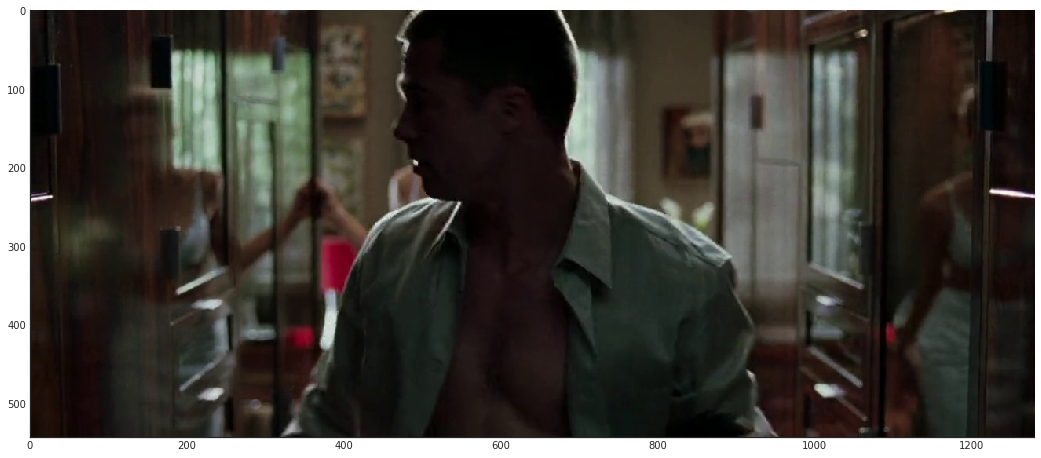

In [161]:
plt.imshow(imgs[0])

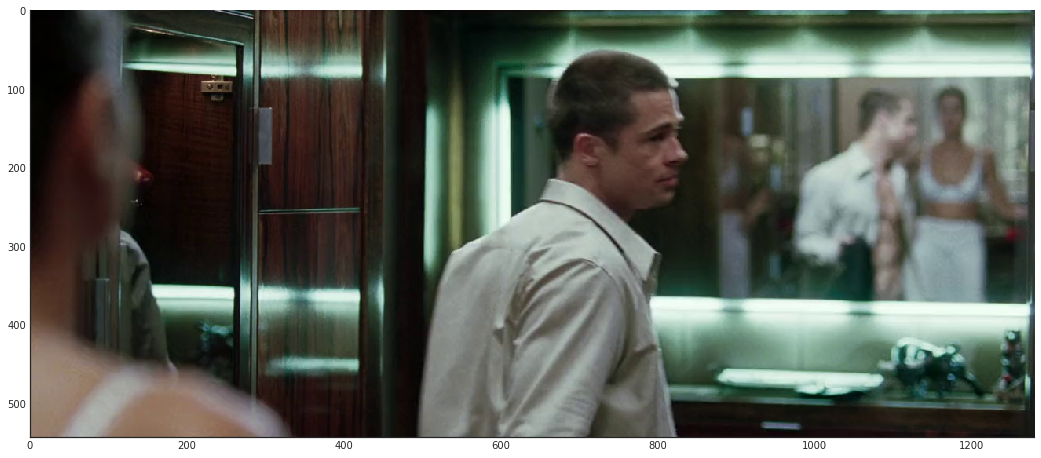

In [162]:
plt.imshow(imgs[1])

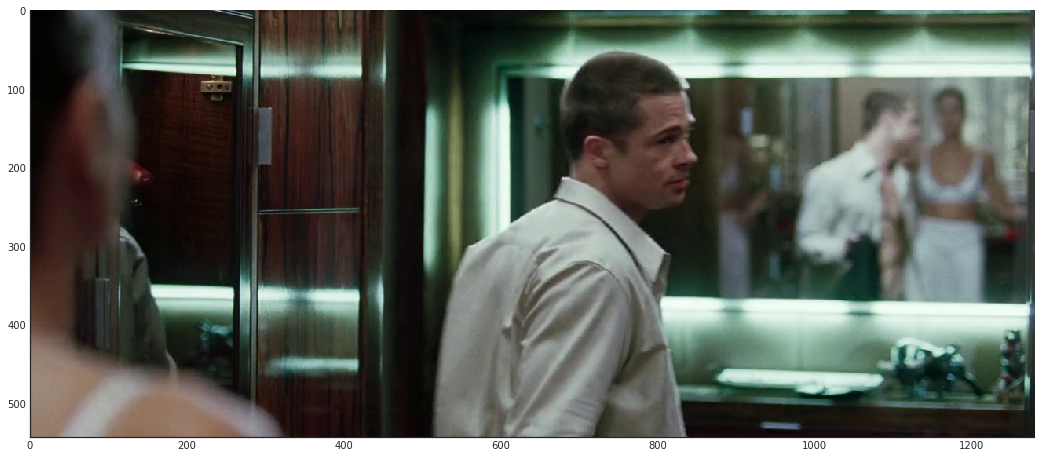

In [163]:
plt.imshow(imgs[2])

In [27]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [28]:
img_tensors = [
    transform(npimg).unsqueeze(0).to(device)
    for npimg in imgs
]

In [298]:
img_tensors[0]

tensor([[[[-0.7569, -0.7569, -0.7569,  ..., -0.9137, -0.8980, -0.8824],
          [-0.7804, -0.7804, -0.7804,  ..., -0.9137, -0.8980, -0.8745],
          [-0.7882, -0.7961, -0.7961,  ..., -0.9216, -0.9059, -0.8824],
          ...,
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451]],

         [[-0.8353, -0.8353, -0.8353,  ..., -0.9529, -0.9529, -0.9529],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9529, -0.9529, -0.9529],
          [-0.8275, -0.8275, -0.8353,  ..., -0.9529, -0.9608, -0.9608],
          ...,
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529],
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529],
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529]],

         [[-0.8353, -0.8353, -0.8353,  ..., -0.9765, -0.9686, -0.9608],
          [-0.8353, -0.8353, -

In [29]:
o = vnet(img_tensors[0], img_tensors[1], img_tensors[2])

In [30]:
o

tensor([[0.5002, 0.5030]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [285]:
model(img_tensors[0], img_tensors[1], img_tensors[2])

tensor([[0.0014]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [168]:
torch.max(o, 1)

(tensor([0.5083], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([1], device='cuda:0'))

In [ ]:
class ShotDetectionDataset(Dataset):
    def __init__(self, shots, window_size=1, height=224):
        """Constrcutor for ShotDetectionDataset.
        
        Args:
            shots: VideoIntervalCollection of all the intervals to get frames from.
        """
        self.window_size = window_size
        frames = set()
        
        for video_id in shots.get_allintervals():
            for intrvl in shots.get_intervallist(video_id).get_intervals():
                for f in range(intrvl.start, intrvl.end + 1):
                    frames.add((video_id, f, 1 if f == intrvl.start else 0))
        self.frames = sorted(list(frames))
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        """
        Indexed by video ID, then frame number
        Returns self.window_size frames before the indexed frame to self.window_size
            frames after the indexed frame
        """
        video_id, frame_num, label = self.frames[idx]
        npimgs = [
            cv2.cvtColor(load_frame(Video.objects.get(id=video_id), f, []), cv2.COLOR_BGR2RGB)
            for f in range(frame_num-self.window_size, frame_num+self.window_size + 1)
        ]
        img_tensors = [
            self.transform(npimg)
            for npimg in imgs
        ]
        
        return img_tensors, label

In [ ]:
dataset = ShotDetectionDataset(shots_gt)

In [ ]:
len(dataset)

In [ ]:
for i in range(len(dataset)):
    sample = dataset[i]
    
    print(i, sample)
    
    if i == 3:
        break

In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    sample, label = sample_batched
    print(i_batch, len(sample))
    print(sample[0].size())
    print(label)
    if i_batch == 3:
        break

In [ ]:
vnet(sample_batched[0], sample_batched[1], sample_batched[2])

In [ ]:
vnet.train()

In [ ]:
outs = vnet(sample_batched[0], sample_batched[1], sample_batched[2])

In [ ]:
torch.max(outs, 1)

In [ ]:
len(list(vnet.modules()))